# Google Analytics Customer Revenue Model
## Sotiris Hadjipanayi - C1615525

In [ ]:
# import section

import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [ ]:
# functions
def constant_cols(df):
    cols = []
    columns = df.columns.values
    for col in columns:
        if df[col].nunique(dropna = False) == 1:
            cols.append(col)
    return cols

def diff_cols(df1,df2):
    columns1 = df1.columns.values
    columns2 = df2.columns.values
    print(list(set(columns1) - set(columns2)))

In [ ]:
json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']
def load_df(csv_path='../Input/train_v2.csv', nrows=100000):
    
    df = pd.read_csv(csv_path, converters={column: json.loads for column in json_cols}, 
                     dtype={'fullVisitorId': 'str'},
                    nrows=nrows)
    
    for column in json_cols:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
        
        print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
        
    return df

print(os.listdir("../Input/"))

In [4]:
%%time
train_df = load_df()
test_df = load_df("../Input/test_v2.csv")

Loaded train_v2.csv. Shape: (100000, 28)
Loaded train_v2.csv. Shape: (100000, 38)
Loaded train_v2.csv. Shape: (100000, 47)
Loaded train_v2.csv. Shape: (100000, 59)
Loaded test_v2.csv. Shape: (100000, 28)
Loaded test_v2.csv. Shape: (100000, 38)
Loaded test_v2.csv. Shape: (100000, 47)
Loaded test_v2.csv. Shape: (100000, 59)
Wall time: 2min 3s


In [5]:
train_df.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserSize,device_browserVersion,device_deviceCategory,device_flashVersion,device_isMobile,device_language,device_mobileDeviceBranding,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_mobileDeviceModel,device_mobileInputSelector,device_operatingSystem,device_operatingSystemVersion,device_screenColors,device_screenResolution,geoNetwork_city,geoNetwork_cityId,geoNetwork_continent,geoNetwork_country,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_networkLocation,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,totals_transactions,totals_visits,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,Western Europe,1,1,1,1,1,NaN,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,water bottle,organic,NaN,google
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,not available in demo dataset,not available in demo dataset,Cupertino,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,(not set),not available in demo dataset,California,Northern America,NaN,2,NaN,2,2,28,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,windjammercable.net,not ava

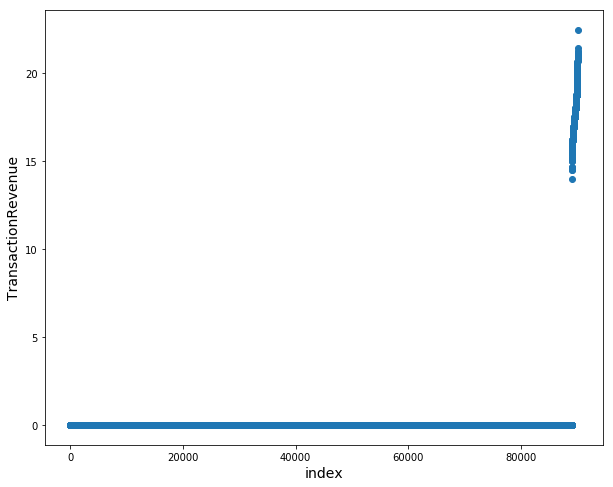

In [9]:
# exploring target variable

train_df["totals_transactionRevenue"] = train_df["totals_transactionRevenue"].astype('float')
groupdf = train_df.groupby("fullVisitorId")["totals_transactionRevenue"].sum().reset_index()

plt.figure(figsize=(10,8))
plt.scatter(range(groupdf.shape[0]), np.sort(np.log1p(groupdf["totals_transactionRevenue"].values)))
plt.xlabel('index', fontsize=14)
plt.ylabel('TransactionRevenue', fontsize=14)
plt.show()

In [10]:
#find instances with non-zero trans.revenue

nonzero_inst = pd.notnull(train_df["totals_transactionRevenue"]).sum()
nonzero_crev = (groupdf["totals_transactionRevenue"]>0).sum()
print("Number of instances in train set with non-zero revenue : ", nonzero_inst, " and ratio is : ", nonzero_inst / train_df.shape[0])
print("Number of unique customers with non-zero revenue : ", nonzero_crev, "and the ratio is : ", nonzero_crev / groupdf.shape[0])

Number of instances in train set with non-zero revenue :  997  and ratio is :  0.00997
Number of unique customers with non-zero revenue :  972 and the ratio is :  0.01078837253182681


In [11]:
print("Number of unique visitors in train set : ",train_df.fullVisitorId.nunique(), " out of rows : ",train_df.shape[0])
print("Number of unique visitors in test set : ",test_df.fullVisitorId.nunique(), " out of rows : ",test_df.shape[0])
print("Number of common visitors in train and test set : ",len(set(train_df.fullVisitorId.unique()).intersection(set(test_df.fullVisitorId.unique())) ))

Number of unique visitors in train set :  90097  out of rows :  100000
Number of unique visitors in test set :  83634  out of rows :  100000
Number of common visitors in train and test set :  259


In [26]:
# find and drop constant columns from datasets

const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False)==1 ]
const_cols


KeyError: "['socialEngagementType' 'device_browserSize' 'device_browserVersion'\n 'device_flashVersion' 'device_language' 'device_mobileDeviceBranding'\n 'device_mobileDeviceInfo' 'device_mobileDeviceMarketingName'\n 'device_mobileDeviceModel' 'device_mobileInputSelector'\n 'device_operatingSystemVersion' 'device_screenColors'\n 'device_screenResolution' 'geoNetwork_cityId' 'geoNetwork_latitude'\n 'geoNetwork_longitude' 'geoNetwork_networkLocation' 'totals_visits'\n 'trafficSource_adwordsClickInfo.criteriaParameters'] not found in axis"

Variables not in test but in train :  set()


In [13]:
# device attributes plot - visists
device_cols = ["device_browser", "device_deviceCategory", "device_operatingSystem"]

colors = ["red", "green", "blue"]
traces = []
for i, col in enumerate(device_cols):
    t = train_df[col].value_counts()
    traces.append(go.Bar(marker=dict(color=colors[i]),orientation="h", y = t.index[:15][::-1], x = t.values[:15][::-1]))

fig = tools.make_subplots(rows=1, cols=3, subplot_titles=["Visits: Category", "Visits: Browser","Visits: OS"], print_grid=False)
fig.append_trace(traces[1], 1, 1)
fig.append_trace(traces[0], 1, 2)
fig.append_trace(traces[2], 1, 3)

fig['layout'].update(height=400, showlegend=False, title="Device Attributes - Visits")
py.iplot(fig)

In [14]:
# convert transaction revenue to float
# device attributes - mean revenue

train_df["totals_transactionRevenue"] = train_df["totals_transactionRevenue"].astype('float')

device_cols = ["device_browser", "device_deviceCategory", "device_operatingSystem"]

fig = tools.make_subplots(rows=1, cols=3, subplot_titles=["Mean Revenue: Category", "Mean Revenue: Browser","Mean Revenue: OS"], print_grid=False)

colors = ["blue", "orange", "indigo"]
trs = []
for i, col in enumerate(device_cols):
    tmp = train_df.groupby(col).agg({"totals_transactionRevenue": "mean"}).reset_index().rename(columns={"totals_transactionRevenue" : "Mean Revenue"})
    tmp = tmp.dropna().sort_values("Mean Revenue", ascending = False)
    tr = go.Bar(x = tmp["Mean Revenue"][::-1], orientation="h", marker=dict(opacity=0.5, color=colors[i]), y = tmp[col][::-1])
    trs.append(tr)

fig.append_trace(trs[1], 1, 1)
fig.append_trace(trs[0], 1, 2)
fig.append_trace(trs[2], 1, 3)
fig['layout'].update(height=400, showlegend=False, title="Device Attributes - Mean Revenue")
py.iplot(fig)

In [15]:
data = train_df[['channelGrouping','totals_transactionRevenue']]
temp = data['channelGrouping'].value_counts()
chart = [go.Pie(labels = temp.index, values = temp.values)]
py.iplot(chart)

In [45]:
import datetime

def _add_date_features(df):
    df['date'] = df['date'].astype(str)
    df["date"] = df["date"].apply(lambda x : datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)x[6:])))
    df["date"] = pd.to_datetime(df["date"])
    
    #train_df['date'] = train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
    
    df["month"]   = df['date'].dt.month
    df["day"]     = df['date'].dt.day
    df["weekday"] = df['date'].dt.weekday
    return df 

train_df = _add_date_features(train_df)

tmp = train_df['date'].value_counts().to_frame().reset_index().sort_values('index')
tmp = tmp.rename(columns = {"index" : "dateX", "date" : "visits"})

tr = go.Scatter(mode="lines", x = tmp["dateX"].astype(str), y = tmp["visits"])
layout = go.Layout(title="Visits by date", height=400)
fig = go.Figure(data = [tr], layout = layout)
iplot(fig)


tmp = train_df.groupby("date").agg({"totals_transactionRevenue" : "mean"}).reset_index()
tmp = tmp.rename(columns = {"date" : "dateX", "totals_transactionRevenue" : "mean_revenue"})
tr = go.Scatter(mode="lines", x = tmp["dateX"].astype(str), y = tmp["mean_revenue"])
layout = go.Layout(title="MonthlyRevenue by date", height=400)
fig = go.Figure(data = [tr], layout = layout)
py.iplot(fig)

SyntaxError: invalid syntax (<ipython-input-45-6f415d0362cb>, line 3)

In [ ]:
def _add_date_features(df):
    df['date'] = df['date'].astype(str)
    df["date"] = df["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
    df["date"] = pd.to_datetime(df["date"])
    
    df["month"]   = df['date'].dt.month
    df["day"]     = df['date'].dt.day
    df["weekday"] = df['date'].dt.weekday
    return df 

train_df = _add_date_features(train_df)

tmp = train_df['date'].value_counts().to_frame().reset_index().sort_values('index')
tmp = tmp.rename(columns = {"index" : "dateX", "date" : "visits"})

tr = go.Scatter(mode="lines", x = tmp["dateX"].astype(str), y = tmp["visits"])
layout = go.Layout(title="Visits by date", height=400)
fig = go.Figure(data = [tr], layout = layout)
iplot(fig)


tmp = train.groupby("date").agg({"totals_transactionRevenue" : "mean"}).reset_index()
tmp = tmp.rename(columns = {"date" : "dateX", "totals_transactionRevenue" : "mean_revenue"})
tr = go.Scatter(mode="lines", x = tmp["dateX"].astype(str), y = tmp["mean_revenue"])
layout = go.Layout(title="MonthlyRevenue by date", height=400)
fig = go.Figure(data = [tr], layout = layout)
iplot(fig)

In [36]:
#vistor profile

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

agg_dict = {}
for col in ["totals_bounces", "totals_hits", "totals_newVisits", "totals_pageviews", "totals_transactionRevenue"]:
    train_df[col] = train_df[col].astype('float')
    agg_dict[col] = "sum"
tmp = train_df.groupby("fullVisitorId").agg(agg_dict).reset_index()
tmp.head()

,fullVisitorId,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_transactionRevenue
0,0000059488412965267,1.0,1.0,1.0,1.0,0.0
1,0000118334805178127,1.0,1.0,1.0,1.0,0.0
2,0000174067426171406,0.0,28.0,1.0,25.0,0.0
3,0000174453501096099,1.0,1.0,1.0,1.0,0.0
4,0000245437374675368,0.0,2.0,1.0,2.0,0.0


There are 972 visitors in the train dataset having non zero total transaction revenue


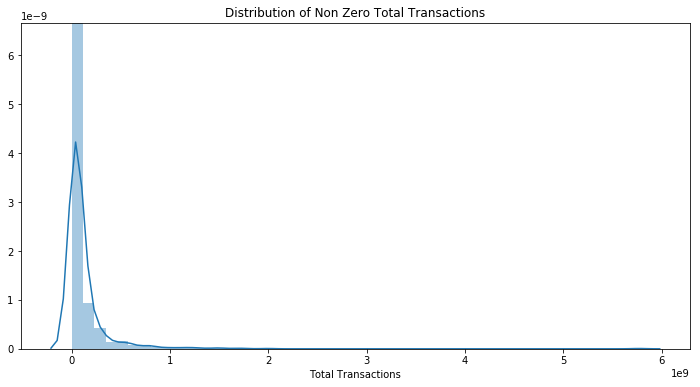

In [39]:
non_zero = tmp[tmp["totals_transactionRevenue"] > 0]["totals_transactionRevenue"]
print ("There are " + str(len(non_zero)) + " visitors in the train dataset having non zero total transaction revenue")

plt.figure(figsize=(12,6))
sns.distplot(non_zero)
plt.title("Distribution of Non Zero Total Transactions");
plt.xlabel("Total Transactions");

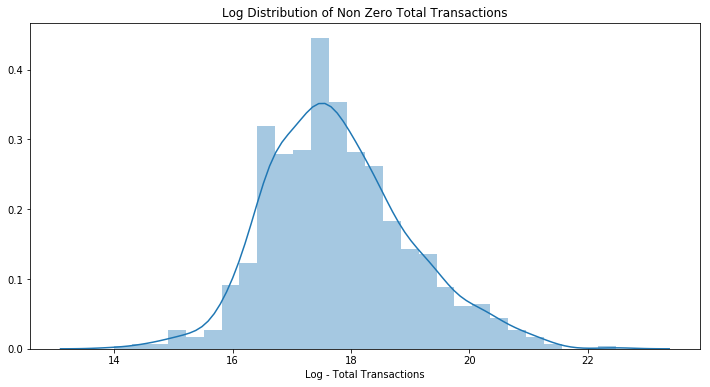

In [40]:
plt.figure(figsize=(12,6))
sns.distplot(np.log1p(non_zero))
plt.title("Log Distribution of Non Zero Total Transactions");
plt.xlabel("Log - Total Transactions");

In [41]:
## find constant columns
constant_columns = []
for col in train_df.columns:
    if len(train_df[col].value_counts()) == 1:
        constant_columns.append(col)

## non relevant columns
non_relevant = ["visitNumber", "date", "fullVisitorId", "sessionId", "visitId", "visitStartTime"]

In [ ]:
def _add_date_features(df):
    df['date'] = df['date'].astype(str)
    df["date"] = df["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
    df["date"] = pd.to_datetime(df["date"])
    
    df["month"]   = df['date'].dt.month
    df["day"]     = df['date'].dt.day
    df["weekday"] = df['date'].dt.weekday
    return df 

